In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from config import password
import pandas as pd

In [2]:
connection_string = f"postgres:{password}@perth-property-market.cptzycsh4y3w.ap-southeast-2.rds.amazonaws.com:5432/perth-property-market"

# Create the database engine (to the PostgreSQL database)
engine = create_engine(f'postgresql://{connection_string}')
conn = engine.connect()
session = Session(bind=engine)

In [3]:
Base = automap_base()

Base.prepare(engine, reflect=True)

market_data = Base.classes.perth_market

In [4]:
properties = session.query(
    market_data.price, market_data.bedrooms, market_data.bathrooms, market_data.land_area,
    market_data.floor_area, market_data.build_year, market_data.cbd_dist, market_data.year_sold).all()

In [5]:
session.close()


In [6]:
property_list = []
for row in properties:
    property = list(np.ravel(row))
    property_list.append(property)
    

df = pd.DataFrame(property_list, columns=["Price", "Bedrooms", "Bathrooms", "Land_Area", 
"Floor_Area", "Build_Year", "CBD_Dist", "Year_Sold"])

df.head(2)

,Price,Bedrooms,Bathrooms,Land_Area,Floor_Area,Build_Year,CBD_Dist,Year_Sold
0,565000,4,2,600,160,2003,18300,2018
1,365000,3,2,351,139,2013,26900,2019


In [17]:
# Round the sale price (i.e. $456000 -> 450000)
df["Price"] = (round(df["Price"]/10000)*10000).astype("int")

# KNN Regression

In [18]:
X = df.drop(["Price"], axis=1)
y = df["Price"].values.reshape(-1, 1)
print(X.shape, y.shape)

(25683, 7) (25683, 1)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [21]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


In [22]:
# KNeighbors regression
from sklearn.neighbors import KNeighborsRegressor


k: 1, Train/Test Score: 1.000/0.401
k: 3, Train/Test Score: 0.792/0.594
k: 5, Train/Test Score: 0.750/0.622
k: 7, Train/Test Score: 0.728/0.639
k: 9, Train/Test Score: 0.718/0.646
k: 11, Train/Test Score: 0.708/0.648
k: 13, Train/Test Score: 0.700/0.650
k: 15, Train/Test Score: 0.695/0.649
k: 17, Train/Test Score: 0.691/0.648
k: 19, Train/Test Score: 0.686/0.648


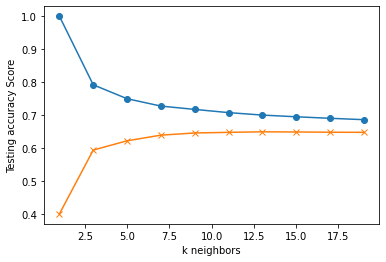

In [23]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_scaled)
    train_score = knn.score(X_train_scaled, y_train_scaled)
    test_score = knn.score(X_test_scaled, y_test_scaled)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [24]:
# Note that k: 13 seems to be the best choice for this dataset
knn = KNeighborsRegressor(n_neighbors=13)
knn.fit(X_train_scaled, y_train_scaled)
print('k=13 Test Acc: %.3f' % knn.score(X_test_scaled, y_test_scaled))

k=13 Test Acc: 0.650


In [25]:
print('k=13 Train Acc: %.3f' % knn.score(X_train_scaled, y_train_scaled))

k=13 Train Acc: 0.700


In [20]:
knn.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 13,
 'p': 2,
 'weights': 'uniform'}

## Save Model

In [15]:
# save the model to disk
import joblib
filename = '../models/price_model_knn.sav'
joblib.dump(knn, filename)

['../models/price_model_knn.sav']

In [16]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test_scaled, y_test_scaled)
print(result)

0.6445961866754174
